# Exploratory Bag-of-Words Modeling 

This notebook uses preprocessed .csv files from the Kiva Max Approver project, and uses word frequency analysis to attempt to predict loan funding status.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# #downloads
nltk.download('vader_lexicon')
nltk.download('wordnet')
# !python -m spacy download en_core_web_lg

## this one isn't working for some reason 
## !python -m spacy download en_trf_bertbaseuncased_lg

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#read in sampled data
#df = pd.read_csv('/content/drive/MyDrive/Colab/group_project/pre_processed_sample.csv').drop(columns = 'Unnamed: 0')

#or read in full dataset
df = pd.read_csv('/content/drive/MyDrive/Colab/group_project/pre_processed_kiva.csv').drop(columns = 'Unnamed: 0')

In [4]:
df.head()

,LOAN_ID,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,STATUS
0,1455352,"['city', 'portoviejo', 'located', 'valley', 'p...","['purchase', 'natural', 'products']","['repeat', 'borrower', 'health', 'and', 'sanit...",1
1,1727469,"['lorna', 'married', 'woman', '39', 'years', '...","['purchase', 'additional', 'stocks', 'avon', '...","['womanowned', 'business', 'parent']",0
2,1747998,"['anita', '32yearold', 'married', 'woman', 're...","['purchase', 'lentils', 'oil', 'salt', 'bulk',...","['womanowned', 'business']",1
3,1342372,"['saeeda', '45yearold', 'woman', 'living', 'sp...","['buy', 'embroidery', 'raw', 'materials', 'thr...","['fabrics', 'womanowned', 'business', 'user_fa...",1
4,1632606,"['pablo', 'enterprising', 'young', 'man', 'dri...","['buy', 'pos', 'point', 'sale', 'terminal', 'm...","['single', 'technology', 'biz', 'durable', 'as...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417540 entries, 0 to 417539
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   LOAN_ID                 417540 non-null  int64 
 1   DESCRIPTION_TRANSLATED  417540 non-null  object
 2   LOAN_USE                417540 non-null  object
 3   TAGS                    417540 non-null  object
 4   STATUS                  417540 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 15.9+ MB


In [6]:
df['STATUS'].value_counts()

1    348399
0     69141
Name: STATUS, dtype: int64

In [7]:
df['STATUS'].value_counts(normalize=True)

1    0.834409
0    0.165591
Name: STATUS, dtype: float64

In [33]:
# take an unbalanced subsample of data
kiva = df.groupby('STATUS').apply(lambda x: x.sample(frac=0.05))
kiva['STATUS'].value_counts(normalize=True)

1    0.834411
0    0.165589
Name: STATUS, dtype: float64

## Model Description_Translated Column

#### Lemmatize for Bag of Words Model

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
kiva['DESCRIPTION_TRANSLATED']  = kiva['DESCRIPTION_TRANSLATED'].apply(lambda x: lemmatizer.lemmatize(x))

#### Model

In [11]:
#set up X and y

X = kiva['DESCRIPTION_TRANSLATED']
y = kiva['STATUS']

In [12]:
#check for baseline
y.value_counts(normalize=True)

1    0.834411
0    0.165589
Name: STATUS, dtype: float64

In [13]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

#### Check Out Top Occuring Words with Count Vectorizer

In [14]:
cvec = CountVectorizer()

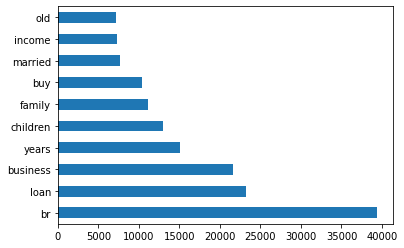

In [15]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

In [16]:
## add in some stopwords - code inspired by varun
my_stop = ['br']
stop_words = my_stop

### Run Through Classifiers

In [17]:
#create a list of the model classes to test
model_list = [
    LogisticRegression(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    SVC()
]

#### CVEC

In [18]:
#vectorize features with ngram range 1,3
cvec = CountVectorizer(stop_words=stop_words, max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_results = pd.DataFrame(classifier_list)
desc_results

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.850548,0.831897,0.820250
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.841447,0.835489,0.835698
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.508772,0.501197,0.506197
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.855158,0.835249,0.835818


#### TVEC

In [19]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
desc_tvec_results = pd.DataFrame(classifier_list)
desc_tvec_results

,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.855697,0.838362,0.837555
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.845758,0.834770,0.836956
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.846237,0.800527,0.807317
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.937788,0.834531,0.838273


## Model LOAN_USE


#### Lemmatize for Bag of Words Model

In [20]:
#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

In [21]:
#lemmatize LOAN_USE column
kiva['LOAN_USE']  = kiva['LOAN_USE'].apply(lambda x: lemmatizer.lemmatize(x))

In [22]:
#set up X and y

X = kiva['LOAN_USE']
y = kiva['STATUS']

In [23]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

### Check Out Top Occurring Words With CountVectorizer


In [24]:
cvec = CountVectorizer()

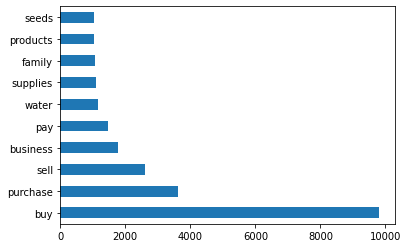

In [25]:
# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

### Run Through the Classifiers

#### CVEC

In [26]:
#vectorize features
cvec = CountVectorizer(stop_words=stop_words, max_features = 1_000, max_df=.98, min_df = 2, ngram_range =(1, 3))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_results = pd.DataFrame(classifier_list)
loan_use_results

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.840728,0.829262,0.827555
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.837375,0.834052,0.834202
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.687683,0.672893,0.683312
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.844321,0.834052,0.833902


#### TVEC

In [27]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
loan_use_tvec_results = pd.DataFrame(classifier_list)
loan_use_tvec_results

,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.841327,0.831897,0.834082
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.839171,0.833333,0.835878
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.832285,0.793822,0.802527
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.873241,0.834770,0.834142


## Model TAGS

In [28]:
#set up X and y

X = kiva['TAGS']
y = kiva['STATUS']

In [29]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 stratify=y,
                                                 random_state=42)

#### Check out Top Occurring Words with CountVectorizer

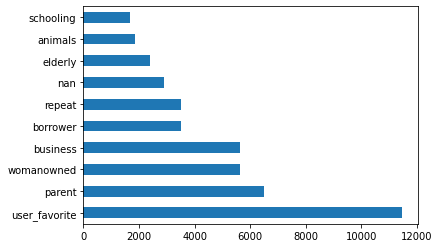

In [30]:
cvec = CountVectorizer()

# convert training data to dataframe
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                         columns=cvec.get_feature_names())


# plot top occurring words
X_train_df_cvec.sum().sort_values(ascending = False).head(10).plot(kind='barh');

#### Model Tags

#### CVEC

In [31]:
#vectorize features with ngram range 1,4
cvec = CountVectorizer(ngram_range =(1, 4))
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
tags_results = pd.DataFrame(classifier_list)
tags_results

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.871145,0.820163,0.821627
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.838453,0.834531,0.832884
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.781929,0.772749,0.763667
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.861326,0.833812,0.833064


#### TVEC

In [32]:
#vectorize features with TF-IDF
tvec = TfidfVectorizer()
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 3).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

#create a dataframe and display dictionary
tags_results_tvec = pd.DataFrame(classifier_list)
tags_results_tvec

,model_name,train_score,test_score,cv_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.833064,0.833094,0.833004
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.838752,0.832375,0.831986
2,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.784324,0.789272,0.782708
3,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.835160,0.834770,0.834441


# Interpretation and Next Steps


*   It does not appear that a bag of words model is predictive of loan success or failure with these supervised learning models, for either of the vectorizers, for any of the text columns. I'm only able to use 5% of the data, but that's still over 40,000 documents.

*   Possible next steps for NLP?
     *  **Sentiment analysis** 
       * **On bag of words?** 
     *  Figure out spacy? NOPE
     * Try a neural net? Worth it? NOPE   